# Chapter 7. Ensemble Learning and Random Forests

Ensemble Learning is a technique rooted in the wisdom of the crowd concept, where aggregated predictions from a group of predictors, known as an ensemble, often outperform individual predictors. An example is the Random Forest algorithm, comprised of Decision Tree classifiers trained on distinct subsets of the training data. 

The ensemble's combined predictions, often determined by majority voting, yield robust results. Ensemble methods, such as bagging, boosting, and stacking, are commonly employed in Machine Learning projects to enhance the performance of existing predictors. This approach has proven successful in various contexts, including competitive Machine Learning competitions like the Netflix Prize. The chapter delves into popular Ensemble methods and explores the influential Random Forest technique.

In [1]:
# Setup

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### Voting Classifiers

Imagine having developed several classifiers, each achieving an approximately 80% accuracy rate. Among these classifiers, you might have implemented a range of models such as Logistic Regression, Support Vector Machine (SVM), Random Forest, K-Nearest Neighbors (K-NN), and potentially others.

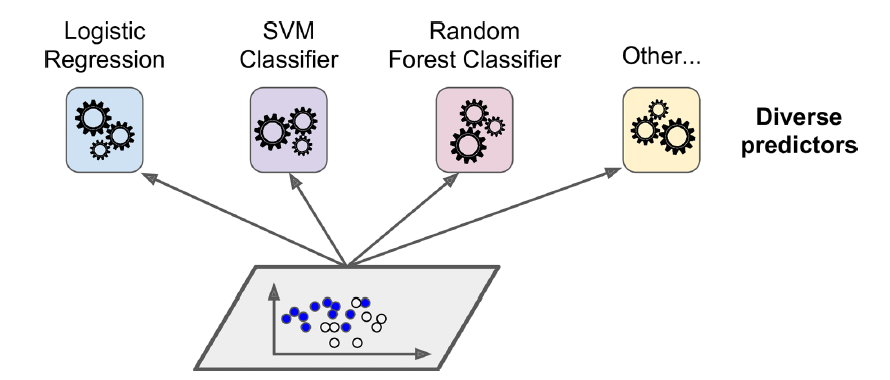

An effective approach to enhance classifier performance involves aggregating the predictions of individual classifiers and subsequently predicting the class that receives the highest number of votes. This amalgamated classifier, employing a majority-vote mechanism, is referred to as a hard voting classifier.

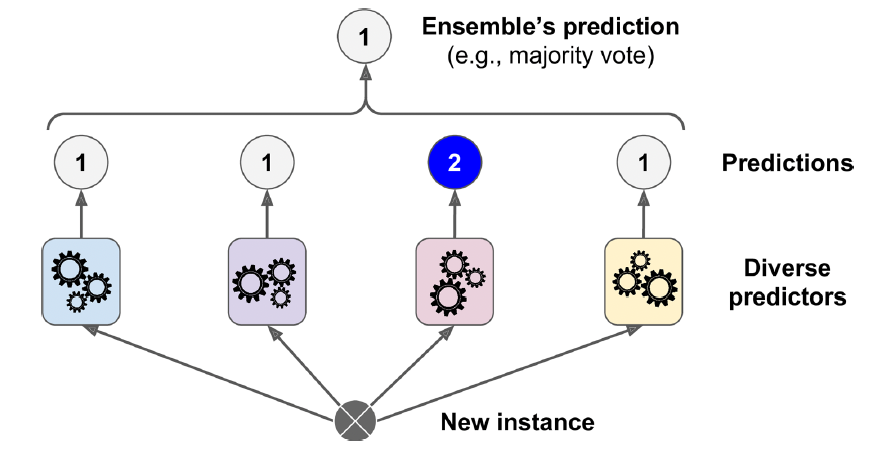

Surprisingly, the hard voting classifier often achieves higher accuracy than the best individual classifier within the ensemble. This phenomenon holds true even if each classifier is a weak learner, performing only marginally better than random guessing. This strength arises from the collective diversity of a sufficient number of weak learners. 

To understand this, consider the analogy of a slightly biased coin that tends to land heads with a 51% probability and tails with 49%. Over many tosses, the proportion of heads converges toward the probability of heads (51%) due to the law of large numbers, resulting in a majority of heads. Similarly, by combining diverse classifiers in an ensemble, even if they are individually weak, the ensemble can emerge as a robust learner, exploiting the underlying principle of convergence toward improved accuracy.

In [8]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

Saving figure law_of_large_numbers_plot


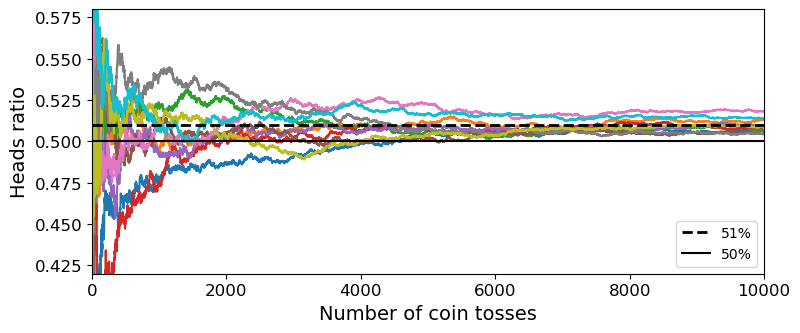

In [9]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
save_fig("law_of_large_numbers_plot")
plt.show()

Likewise, consider an ensemble comprised of 1,000 classifiers, each with an individual accuracy of just 51%, slightly surpassing random chance. Employing majority voting, this ensemble could yield an accuracy of approximately 75%, assuming ideal independence and uncorrelated errors among classifiers. However, this assumption is unrealistic since the classifiers are trained on the same data, leading to shared error patterns. Consequently, numerous erroneous majority votes for an incorrect class may occur, diminishing the ensemble's overall accuracy.

The provided code snippet utilizes Scikit-Learn to establish and train a voting classifier, consisting of three distinct classifiers. The training data employed is sourced from the moons dataset, previously introduced in Chapter 5.

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()
voting_clf = VotingClassifier(
estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [7]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.904
SVC 0.896
VotingClassifier 0.904


In [11]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [12]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


### Bagging and Pasting

Creating diversity among classifiers can be achieved through distinct training algorithms, as previously explained. Alternatively, a similar training algorithm can be applied across multiple predictors, trained on varied random subsets of the training set. This process is termed bagging (bootstrap aggregating) when training instances are sampled with replacement, and pasting when sampling is without replacement. Essentially, both bagging and pasting involve multiple samplings of training instances across predictors, but bagging uniquely permits repeated sampling of instances for the same predictor.

After training, the ensemble of predictors can collectively predict new instances by aggregating their individual predictions, often using the statistical mode for classification or the average for regression, which mitigates both bias and variance. While each predictor has higher bias compared to if it were trained on the original dataset, ensemble aggregation balances bias and variance. Consequently, the ensemble exhibits a comparable bias but reduced variance compared to an individual predictor trained on the original data. Notably, this aggregation process can be executed in parallel across multiple CPU cores or servers, exemplifying the scalability of methods like bagging and pasting,

In [13]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [14]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [19]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [20]:
# Figure 7.5 - A single Decision Tree (left) versus a bagging ensemble of 500 trees (right):

from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

Saving figure decision_tree_without_and_with_bagging_plot


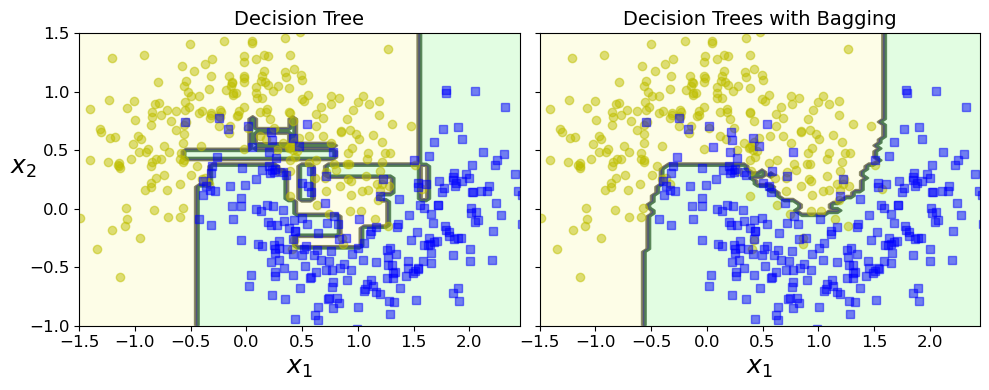

In [21]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

#### Out-of-Bag evaluation

In the context of bagging, certain instances within the training set might be sampled multiple times for a given predictor, while others may not be sampled at all. By default, the BaggingClassifier in Scikit-Learn employs replacement when sampling m training instances (bootstrap=True), where m is the training set size, resulting in an average sampling of approximately 63% per predictor. 

These unselected instances, constituting about 37% of the data, are termed out-of-bag (oob) instances. Crucially, since predictors never encounter oob instances during training, they can be used for evaluation without necessitating a separate validation set. Evaluation of the ensemble itself can be accomplished by averaging the oob evaluations from individual predictors. In Scikit-Learn, setting oob_score=True when initializing a BaggingClassifier triggers automatic oob evaluation post-training, with the evaluation score accessible via the oob_score_ variable.

In [22]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

In [23]:
bag_clf.oob_decision_function_


array([[0.32275132, 0.67724868],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.09497207, 0.90502793],
       [0.31147541, 0.68852459],
       [0.01754386, 0.98245614],
       [0.97109827, 0.02890173],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.7173913 , 0.2826087 ],
       [0.85026738, 0.14973262],
       [0.97222222, 0.02777778],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97837838, 0.02162162],
       [0.94642857, 0.05357143],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.39473684, 0.60526316],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.97790055, 0.02209945],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.62569832, 0.37430168],
       [0.

In [24]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

### Random Forests

As previously explained, a Random Forest constitutes an ensemble of Decision Trees often trained using bagging (or occasionally pasting) technique, usually with max_samples configured to match the training set size. Rather than constructing a BaggingClassifier and supplying a DecisionTreeClassifier, the RandomForestClassifier class can be employed, offering greater convenience and optimization for Decision Trees. Similarly, for regression tasks, the RandomForestRegressor class is available. The provided code snippet demonstrates the utilization of all available CPU cores to train a Random Forest classifier encompassing 500 trees, each constrained to a maximum of 16 nodes.

In [25]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

Apart from a few exceptions, a RandomForestClassifier shares the hyperparameters of a DecisionTreeClassifier for regulating tree growth, and incorporates the hyperparameters of a BaggingClassifier to manage the ensemble itself. 

The distinguishing feature of the Random Forest algorithm is the introduction of additional randomness during tree development: rather than seeking the optimal feature for node splitting, the algorithm identifies the best feature from a random subset. 

This approach enhances tree diversity, striking a balance between bias and variance, and typically yielding improved model performance. The subsequent BaggingClassifier bears resemblance to the previous RandomForestClassifier, offering a similar functionality.

In [26]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, random_state=42)

In [27]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [28]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # very similar predictions


1.0

##### Feature Importance

Random Forests offer a convenient means to assess the relative significance of each feature. In Scikit-Learn, this is quantified by analyzing the extent to which a feature reduces impurity across tree nodes, computed as a weighted average based on the associated training samples. 

After training, Scikit-Learn automatically calculates this importance score for each feature and normalizes the results to ensure a sum of 1. This score can be accessed using the feature_importances_ variable. As illustrated with an example using the RandomForestClassifier on the iris dataset, it becomes apparent that petal length and width are most influential (44% and 42% importance, respectively), while sepal length and width have notably lower importance (11% and 2%, respectively).

In [29]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [30]:
rnd_clf.feature_importances_


array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

The following figure overlays the decision boundaries of 15 decision trees. As you can see, even though each decision tree is imperfect, the ensemble defines a pretty good decision boundary:

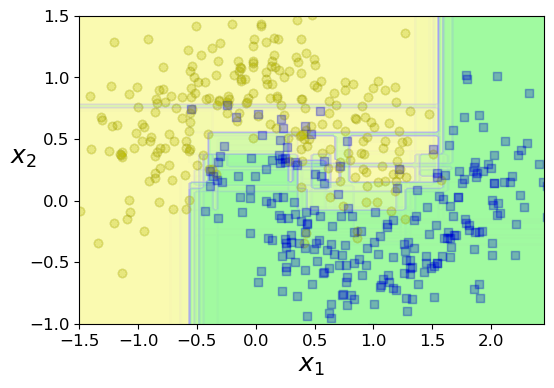

In [31]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X_train[indices_with_replacement], y_train[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.02, contour=False)

In [ ]:
# Figure 7–6. MNIST pixel importance (according to a Random Forest classifier):

from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [33]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(random_state=42)

In [34]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

Saving figure mnist_feature_importance_plot


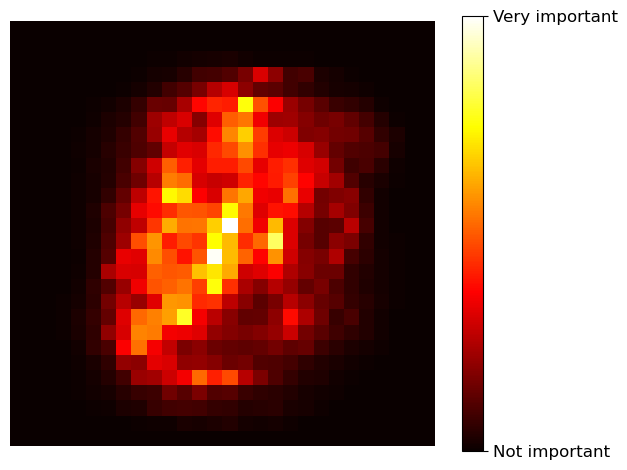

In [35]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

save_fig("mnist_feature_importance_plot")
plt.show()

### Boosting

Boosting, initially termed hypothesis boosting, encompasses a class of Ensemble methods designed to aggregate multiple weak learners into a robust one. The core concept in most boosting techniques involves training predictors in sequence, with each aiming to rectify the errors of its predecessor. Among the array of boosting methods, the prominent ones include AdaBoost (Adaptive Boosting) and Gradient Boosting. This discussion begins with an exploration of AdaBoost.

#### AdaBoost

AdaBoost employs a corrective approach to enhance its predictors by emphasizing instances that were inadequately modeled by preceding predictors. This technique involves iteratively training classifiers, such as Decision Trees, and adjusting instance weights based on prediction accuracy. 

Initially, a base classifier is trained, and its predictions on the training set guide weight adjustments for misclassified instances. Subsequent classifiers are trained using the updated weights, progressively focusing on challenging cases. This iterative process enables AdaBoost to improve its overall predictive capability by iteratively refining its emphasis on difficult instances.

In [36]:

from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

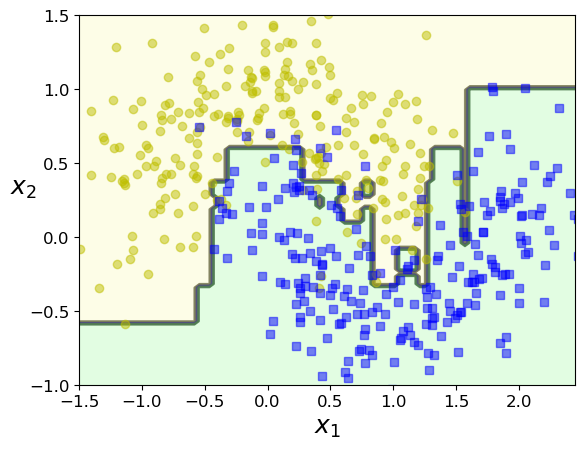

In [37]:
plot_decision_boundary(ada_clf, X, y)


Saving figure boosting_plot


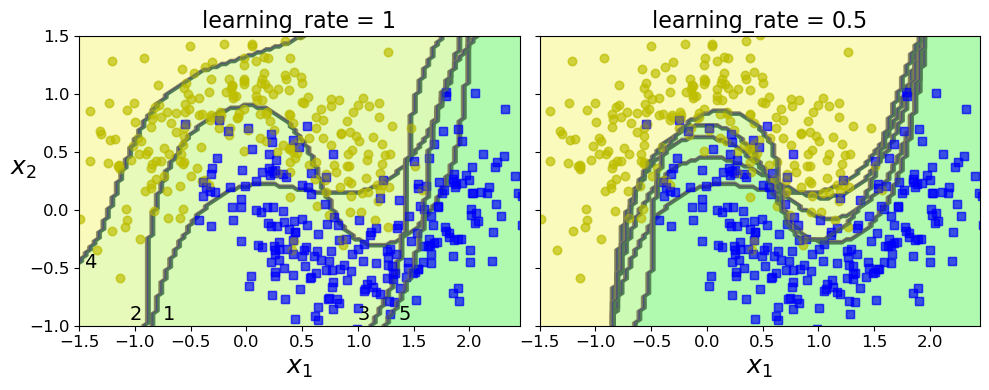

In [40]:
# Figure 7-8 - Decision boundaries of consecutive predictors:

m = len(X_train)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)

        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum() # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r) # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha) # equation 7-3
        sample_weights /= sample_weights.sum() # normalization step

        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=14)
        plt.text(-1.05, -0.95, "2", fontsize=14)
        plt.text(1.0, -0.95, "3", fontsize=14)
        plt.text(-1.45, -0.5, "4", fontsize=14)
        plt.text(1.36,  -0.95, "5", fontsize=14)
    else:
        plt.ylabel("")

save_fig("boosting_plot")
plt.show()

### Gradient Boosting

Gradient Boosting, a highly popular boosting algorithm, follows a sequential approach similar to AdaBoost, wherein predictors are incrementally added to an ensemble to rectify the mistakes of their predecessors. Unlike AdaBoost's manipulation of instance weights, Gradient Boosting focuses on fitting new predictors to the residual errors generated by preceding predictors. 

Specifically, in the context of regression, Gradient Tree Boosting (or Gradient Boosted Regression Trees - GBRT) employs Decision Trees as base predictors. Through this process, the algorithm enhances the ensemble's predictive performance. To illustrate, a DecisionTreeRegressor is initially fitted to the training dataset, forming the foundation of the Gradient Boosting process.

In [42]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [43]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [44]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [45]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [46]:
X_new = np.array([[0.8]])


In [47]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))


In [48]:
y_pred


array([0.75026781])

In [ ]:
# Figure 7–9. In this depiction of Gradient Boosting, the first predictor (top left) is trained normally, 
# then each consecutive predictor (middle left and lower left) is trained on the previous predictor’s residuals; 
# the right column shows the resulting ensemble’s predictions



In [49]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

Saving figure gradient_boosting_plot


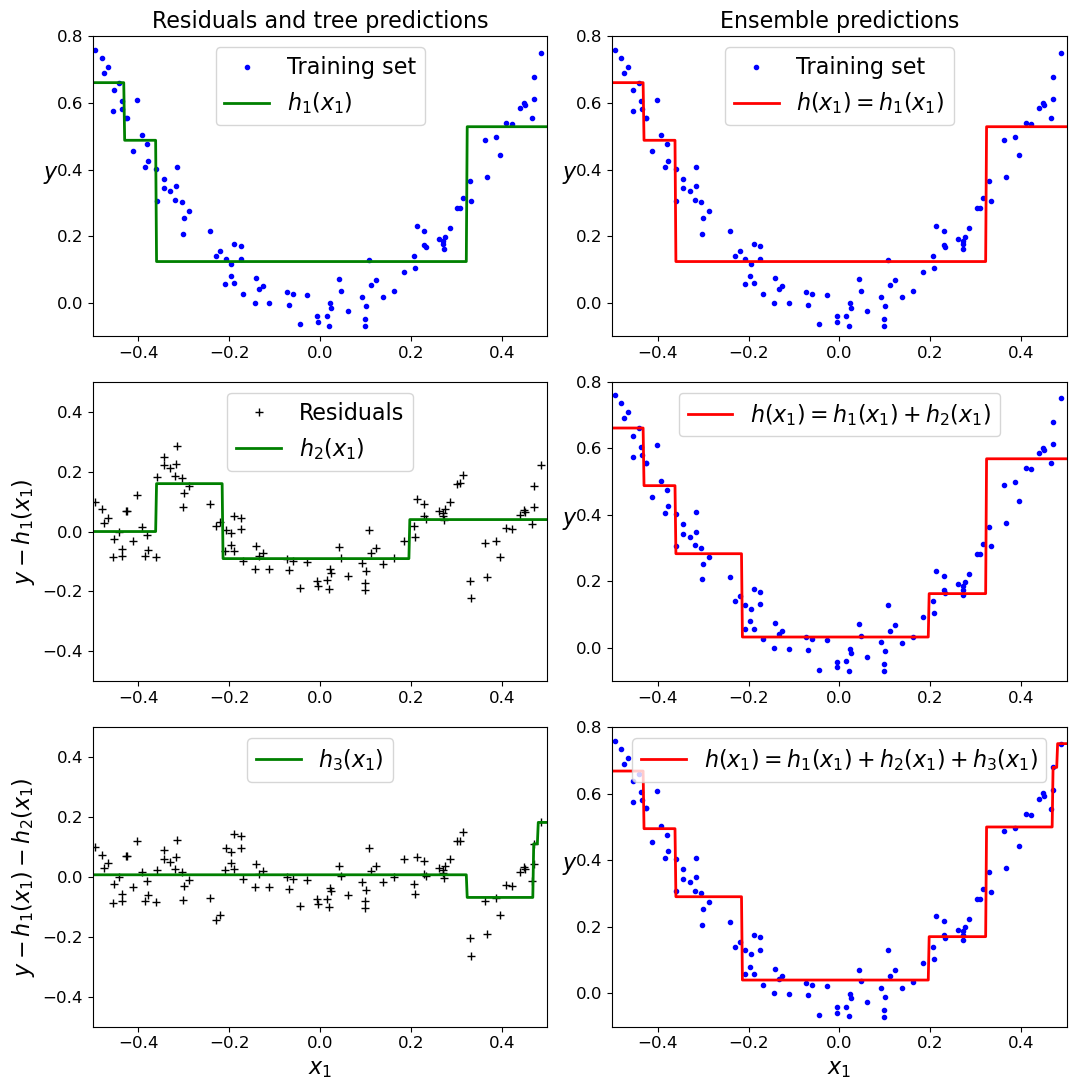

In [50]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()

In [51]:
# GB Regressor

from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [52]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

Saving figure gbrt_learning_rate_plot


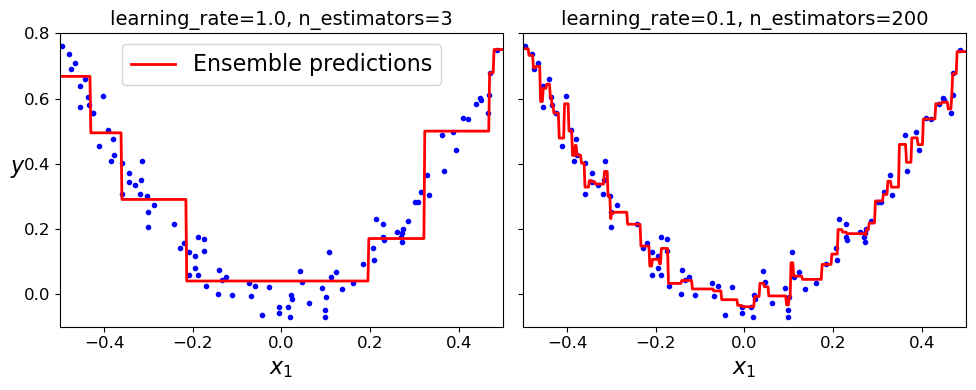

In [53]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

save_fig("gbrt_learning_rate_plot")
plt.show()

In [54]:
# Gradient Boosting with Early stopping:



import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42)

In [55]:
min_error = np.min(errors)


Saving figure early_stopping_gbrt_plot


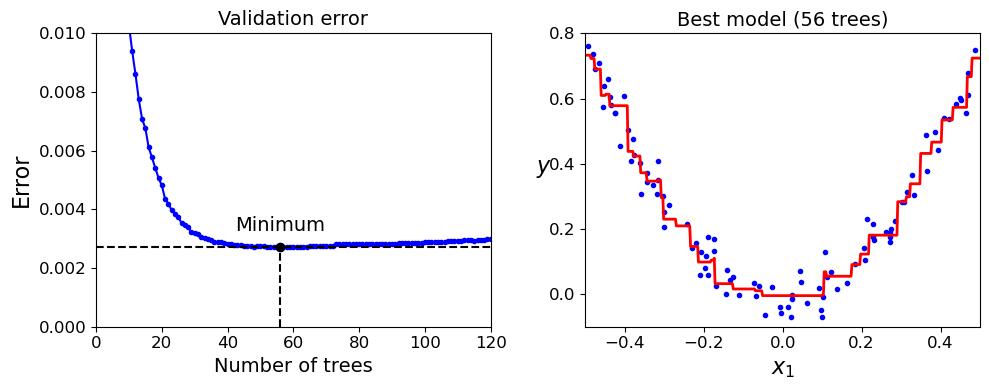

In [56]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(np.arange(1, len(errors) + 1), errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

save_fig("early_stopping_gbrt_plot")
plt.show()

In [57]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [58]:
print(gbrt.n_estimators)


61


In [59]:
print("Minimum validation MSE:", min_val_error)


Minimum validation MSE: 0.002712853325235463


In [64]:
try:
    import xgboost
except ImportError as ex:
    print("Error: the xgboost library is not installed.")
    xgboost = None

In [65]:
if xgboost is not None:  # not shown in the book
    xgb_reg = xgboost.XGBRegressor(random_state=42)
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred) # Not shown
    print("Validation MSE:", val_error) 

Validation MSE: 0.004000408205406276


In [66]:
if xgboost is not None:  # not shown in the book
    xgb_reg.fit(X_train, y_train,
                eval_set=[(X_val, y_val)], early_stopping_rounds=2)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)  # Not shown
    print("Validation MSE:", val_error)            # Not shown

[0]	validation_0-rmse:0.22834
[1]	validation_0-rmse:0.16224
[2]	validation_0-rmse:0.11843
[3]	validation_0-rmse:0.08760
[4]	validation_0-rmse:0.06848
[5]	validation_0-rmse:0.05709
[6]	validation_0-rmse:0.05297
[7]	validation_0-rmse:0.05129
[8]	validation_0-rmse:0.05155
[9]	validation_0-rmse:0.05211
Validation MSE: 0.002630868681577655


/Users/daniloneves/opt/anaconda3/envs/tf/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


In [67]:
%timeit xgboost.XGBRegressor().fit(X_train, y_train) if xgboost is not None else None


48 ms ± 7.99 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [68]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)


28.3 ms ± 858 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


The GradientBoostingRegressor class introduces the subsample hyperparameter, allowing specification of the fraction of training instances used to train each tree. For instance, when subsample=0.25, trees are trained on a random 25% subset of instances, presenting a bias-variance trade-off that decreases variance and accelerates training, known as Stochastic Gradient Boosting. 

Furthermore, it's notable that Gradient Boosting can accommodate alternative cost functions through the loss hyperparameter. Additionally, a highly optimized version of Gradient Boosting, known as XGBoost (Extreme Gradient Boosting), exists within the Python library XGBoost. Developed by Tianqi Chen as part of the Distributed (Deep) Machine Learning Community, XGBoost prioritizes speed, scalability, and portability, often serving as a key component in successful machine learning endeavors.

### Stacking

The final Ensemble method discussed is stacking (short for stacked generalization), which suggests a departure from basic aggregation techniques like hard voting. Instead of straightforward aggregation, the stacking approach involves training a model to execute this aggregation. The ensemble, as depicted, undertakes a regression task on a new instance, with the lower-level predictors producing distinct predictions (e.g., 3.1, 2.7, and 2.9). Subsequently, a final predictor, referred to as a blender or meta learner, employs these predictions as inputs to yield the ultimate prediction (e.g., 3.0).

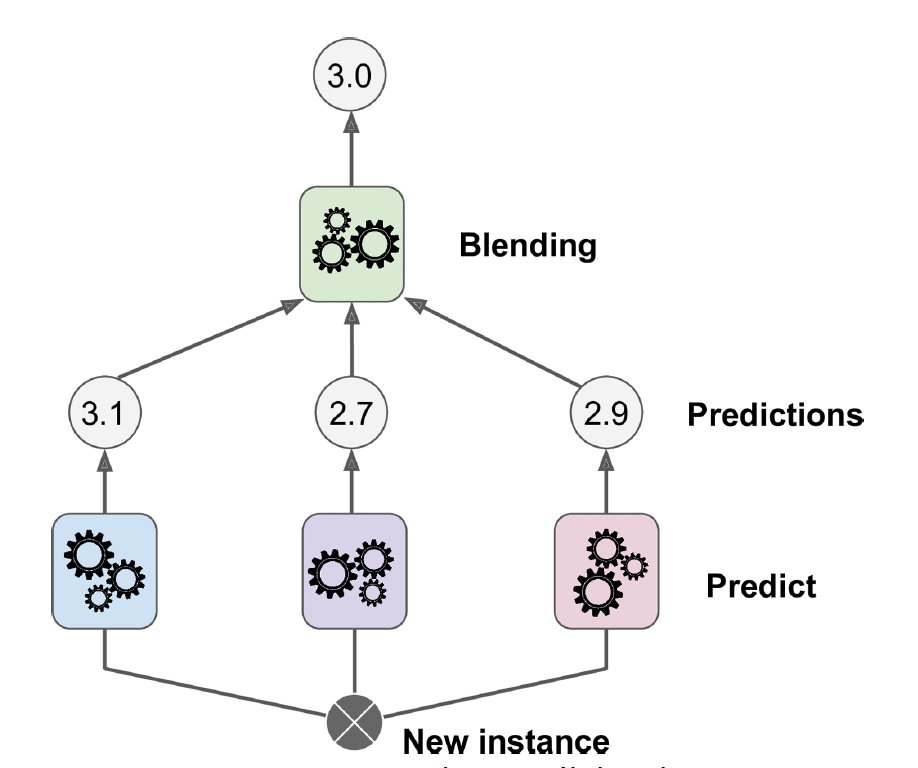

The training of a blender involves a common practice of utilizing a hold-out set, where the training set is divided into two subsets. The initial subset is employed for training the predictors in the first layer, whose subsequent predictions on the second subset, not seen during their training, create a clean set of predictions. 

For each instance in this second subset, a new training set is constructed, incorporating the three predicted values as features along with the original target values. The blender is then trained on this augmented training set to predict the target value based on the initial layer's predictions. 

This process can be extended to train multiple blenders using different algorithms for each layer, involving a systematic partitioning of the training set into subsets for multi-layer training. Sequentially processing through each layer enables making predictions for new instances.